## Importing data from Yahoo finance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [9]:
yf.__version__

'0.1.85'

In [10]:
tickers = ['AMZN','AAPL','BRK-A','XOM','MSFT','TSLA','UNH']

In [11]:
data = yf.download(tickers, start="2017-11-14",end="2022-11-14")
prices = data['Adj Close']
prices.tail()

#putting stock prices into dataframe using yfinance package

[*********************100%***********************]  7 of 7 completed


,AAPL,AMZN,BRK-A,MSFT,TSLA,UNH,XOM
Date,,,,,,,
2022-11-07,138.919998,90.529999,438575.0,227.869995,197.080002,545.020020,113.639999
2022-11-08,139.500000,89.980003,442100.0,228.869995,191.300003,553.049988,114.000000
2022-11-09,134.869995,86.139999,435945.0,224.509995,177.589996,540.659973,108.900002
2022-11-10,146.869995,96.629997,457665.0,242.979996,190.720001,544.169983,110.500000
2022-11-11,149.699997,100.790001,469047.0,247.110001,195.970001,522.080017,113.949997


In [12]:
market_prices = yf.download("SPY", start="2017-11-14", end="2022-11-14")["Adj Close"]
market_prices.head()

#putting S&P 500 prices from the same period into a pandas series

[*********************100%***********************]  1 of 1 completed


Date
2017-11-14    236.508163
2017-11-15    235.324417
2017-11-16    237.324844
2017-11-17    236.627457
2017-11-20    237.031235
Name: Adj Close, dtype: float64

In [13]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info['marketCap']
mcaps

#making a dictionary of the latest market caps of each stock

{'AMZN': 1028229365760,
 'AAPL': 2381442449408,
 'BRK-A': 683190779904,
 'XOM': 469279113216,
 'MSFT': 1842074091520,
 'TSLA': 618824269824,
 'UNH': 487804928000}

## Constructing the prior

Instructions for installing pypfopt: 
https://pyportfolioopt.readthedocs.io/en/latest/index.html

(requires C++ to be installed, also requires numpy and pandas to run)

In [19]:
import pypfopt

In [20]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

#delta is the 'market implied risk premium', more detail below
#instructions for installing pypfopt:
https://pyportfolioopt.readthedocs.io/en/latest/index.html

2.354381656772395

<AxesSubplot:>

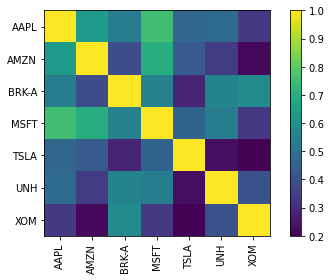

In [16]:
plotting.plot_covariance(S,plot_correlation=True)

In [21]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL     0.212469
AMZN     0.196388
BRK-A    0.114125
MSFT     0.196562
TSLA     0.280025
UNH      0.131907
XOM      0.117426
dtype: float64

<AxesSubplot:>

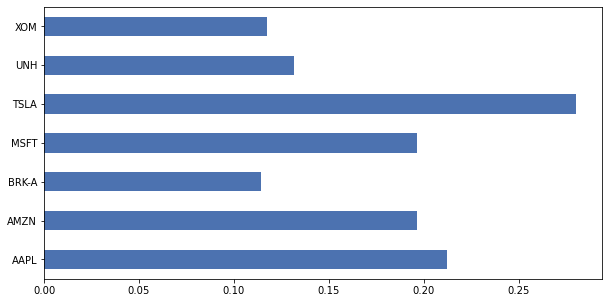

In [22]:
market_prior.plot.barh(figsize=(10,5))

### Explanation

What it just calculated was the 'market implied returns' vector (Pi), which is equal to the product of the covariance matrix of asset returns (Sigma) and a vector of weightings proportional to market cap (w_mkt), multiplied by the market-implied risk premium (delta).

Market-implied risk premium = excess return / variance

Next step: add in views vector Q and picking matrix P, which together encode all the information about our predictions, which are either of the form 'Stock X will change by A%' or 'Stock X will outperform stock Y by B%'.

See https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#priors for more details